## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---


In [1]:
import numpy as np 
import cv2 
import glob 
import matplotlib.pyplot as plt
%matplotlib inline

## Camera calibration 

In [2]:

def camera_calibration(nx,ny):
    
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((nx*ny,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Make a list of calibration images
    images = glob.glob('../camera_cal/calibration*.jpg')

    # Step through the list and search for chessboard corners
    for fname in images:
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx,ny),None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

            # Draw and display the corners
            img = cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    return mtx, dist

In [3]:
def calc_distort(img,mtx,dist):
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist 

### Color and gradient threshold

In [4]:
# Gradient calculation 
def abs_sobel_thresh(img, orient='x', thresh_min=0, thresh_max=255):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Return the result
    return binary_output

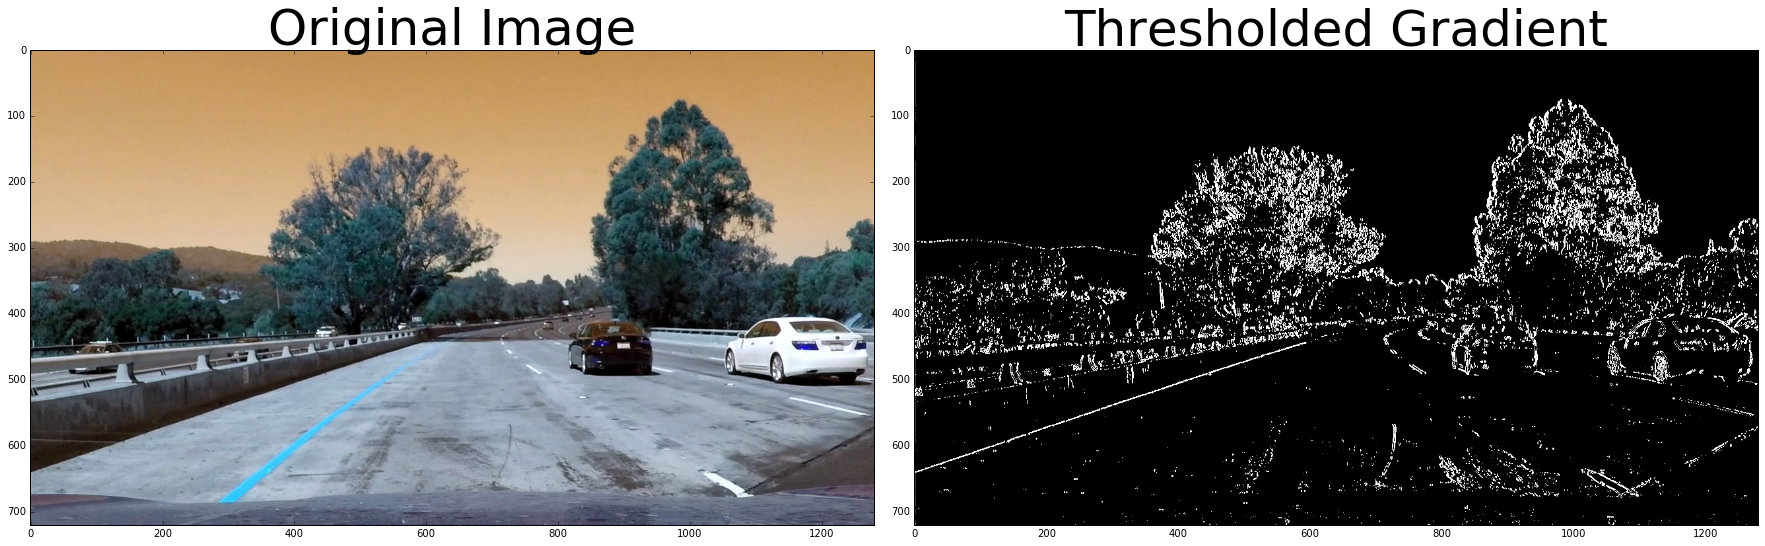

In [5]:
image = cv2.imread("../test_images/test1.jpg")
# Run the function
grad_binary = abs_sobel_thresh(image, orient='x', thresh_min=20, thresh_max=100)
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(grad_binary, cmap='gray')
ax2.set_title('Thresholded Gradient', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [6]:
# Magnitude of the gradient 
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):  
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize= sobel_kernel) 
    # 3) Calculate the magnitude 
    mag = np.sqrt(sobelx**2 + sobely**2)
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scale_factor = np.max(mag)/255 
    mag = (mag/scale_factor).astype(np.uint8) 
    # 5) Create a binary mask where mag thresholds are met
    binary_output = np.zeros_like(mag)
    # 6) Return this mask as your binary_output image
    binary_output[(mag >= mag_thresh[0]) & (mag <= mag_thresh[1])] = 1
    return binary_output

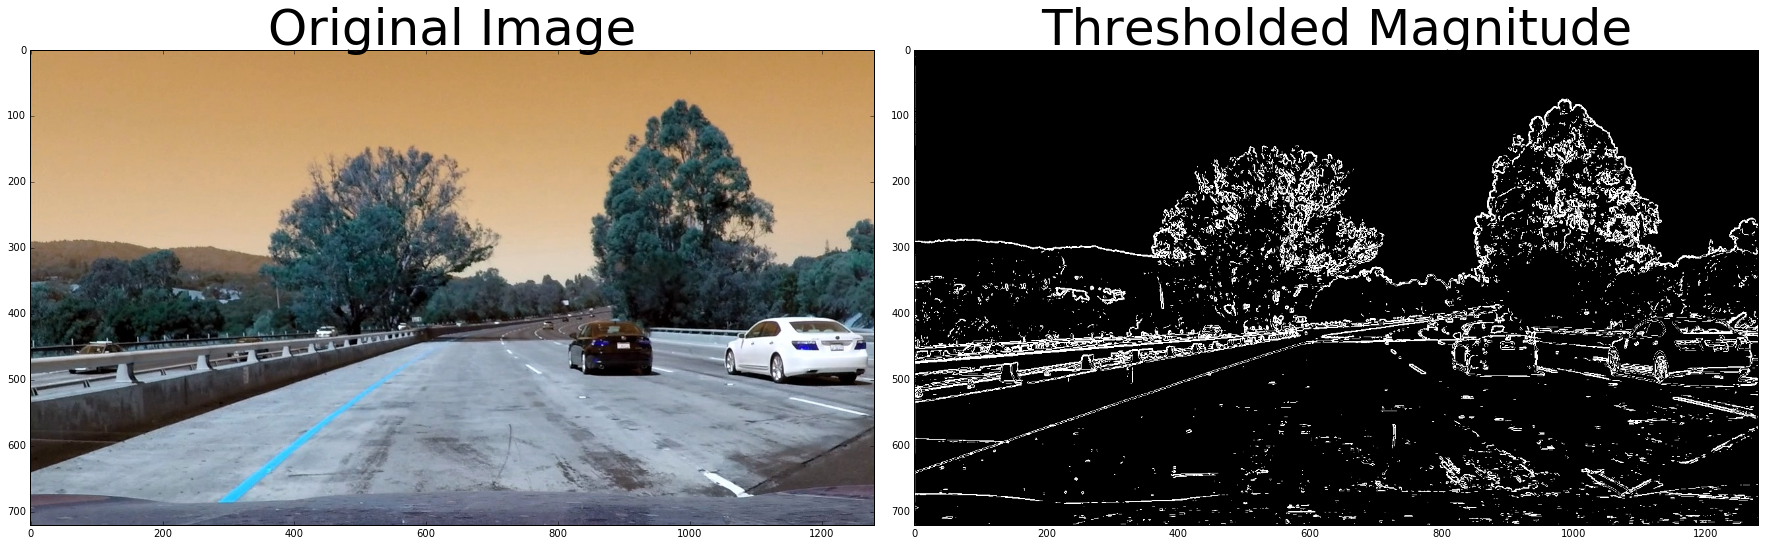

In [7]:
image = cv2.imread("../test_images/test1.jpg")
# Run the function
mag_binary = mag_thresh(image, sobel_kernel=3, mag_thresh=(30, 100))
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(mag_binary, cmap='gray')
ax2.set_title('Thresholded Magnitude', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [8]:
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    # 3) Take the absolute value of the x and y gradients
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    # 5) Create a binary mask where direction thresholds are met
    binary_output =  np.zeros_like(absgraddir)
    # 6) Return this mask as your binary_output image
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    return binary_output


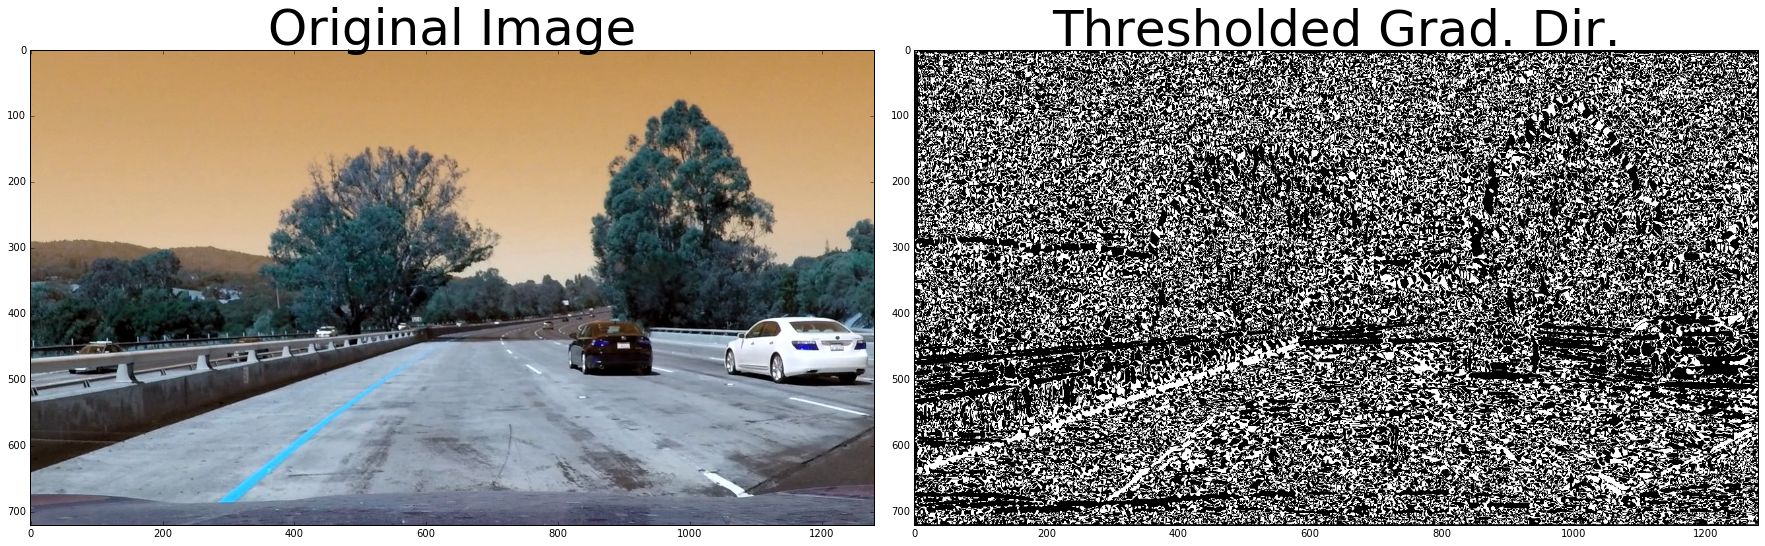

In [9]:
image = cv2.imread("../test_images/test1.jpg")    
# Run the function
dir_binary = dir_threshold(image, sobel_kernel=15, thresh=(0.7, 1.3))
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(dir_binary, cmap='gray')
ax2.set_title('Thresholded Grad. Dir.', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

####  RGB and HLS channel images 

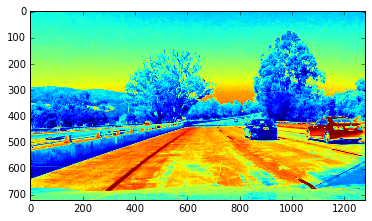

In [10]:
image = cv2.imread("../test_images/test1.jpg")   
R_channel = image[:,:,0]
#plt.imshow(R_channel)
G_channel = image[:,:,1]
#plt.imshow(G_channel)
B_channel = image[:,:,2]
plt.imshow(B_channel)


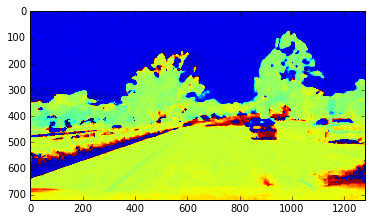

In [11]:
image = cv2.imread("../test_images/test1.jpg")  
hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
h = hls[:,:,0]
plt.imshow(h)

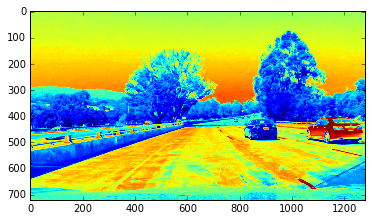

In [12]:
l = hls[:,:,1]
plt.imshow(l)

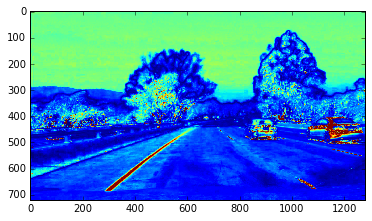

In [13]:
s = hls[:,:,2]
plt.imshow(s)

In [14]:
### Combined color and gradient 
def combined_color(img):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    s_channel = hls[:,:,2]
    sobelx = cv2.Sobel(s_channel, cv2.CV_64F, 1, 0)
    abs_sobelx = np.absolute(sobelx)
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    thresh_min = 20
    thresh_max = 100
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    s_thresh_min = 170
    s_thresh_max = 255
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    return color_binary, combined_binary 

####  Combined thresholded image 

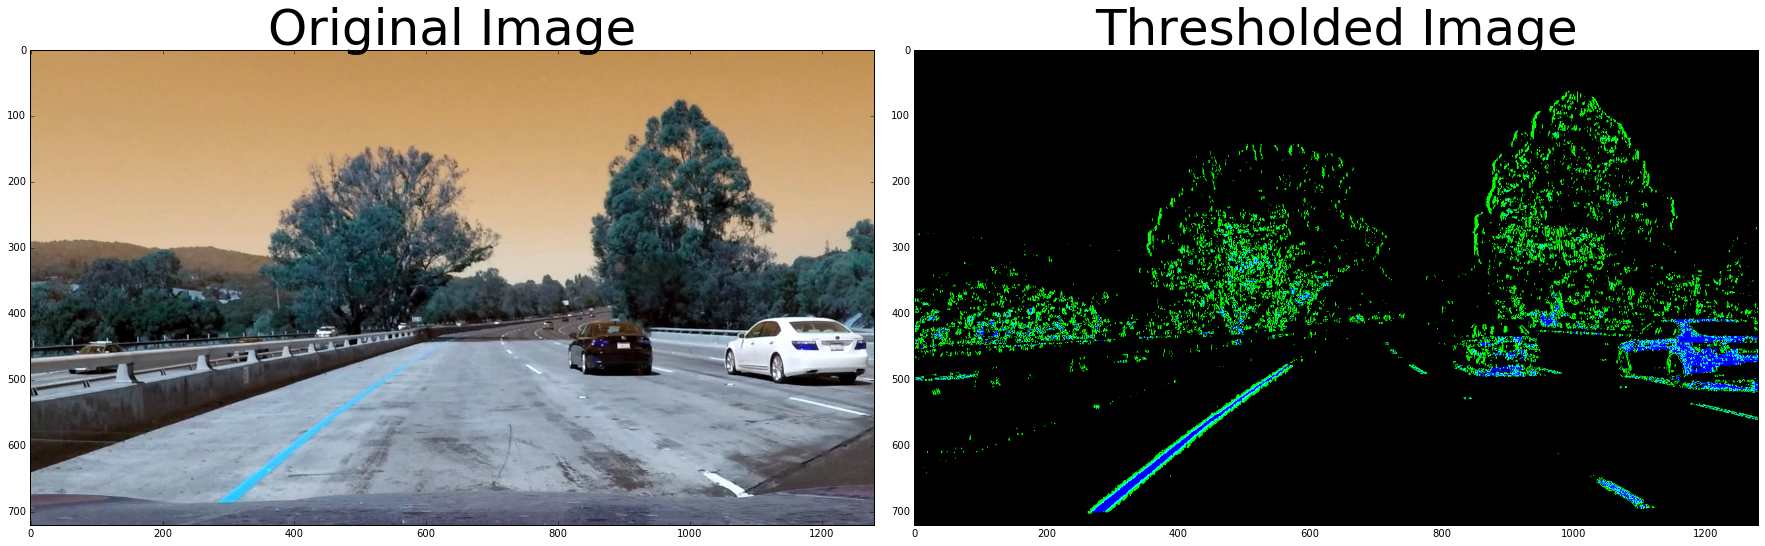

In [16]:
image = cv2.imread("../test_images/test1.jpg")
mtx,dist= camera_calibration(9,6)
undist = calc_distort(image,mtx,dist)
result_color,result_combined = combined_color(undist)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title("Original Image", fontsize = 50)
ax2.imshow(result_color)
ax2.set_title("Thresholded Image", fontsize = 50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

### Apply a perspective transform

In [17]:
src = np.asarray([[240, 686], [1060, 686], [738, 480], [545 ,480]], np.float32)
dst = np.asarray([[300, 700], [1000, 700], [1000 , 300], [300, 300]], np.float32)
def perspective_transform(image,nx = 9):
    offset = 100
    img_size = (image.shape[1], image.shape[0])
    #src = np.float32([corners[0], corners[nx-1], corners[-1], corners[-nx]])
    #dst = np.float32([[offset, offset], [img_size[0]-offset, offset], 
                                     #[img_size[0]-offset, img_size[1]-offset], 
                                     #[offset, img_size[1]-offset]]) 
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(image, M, img_size, flags=cv2.INTER_LINEAR)
    return warped

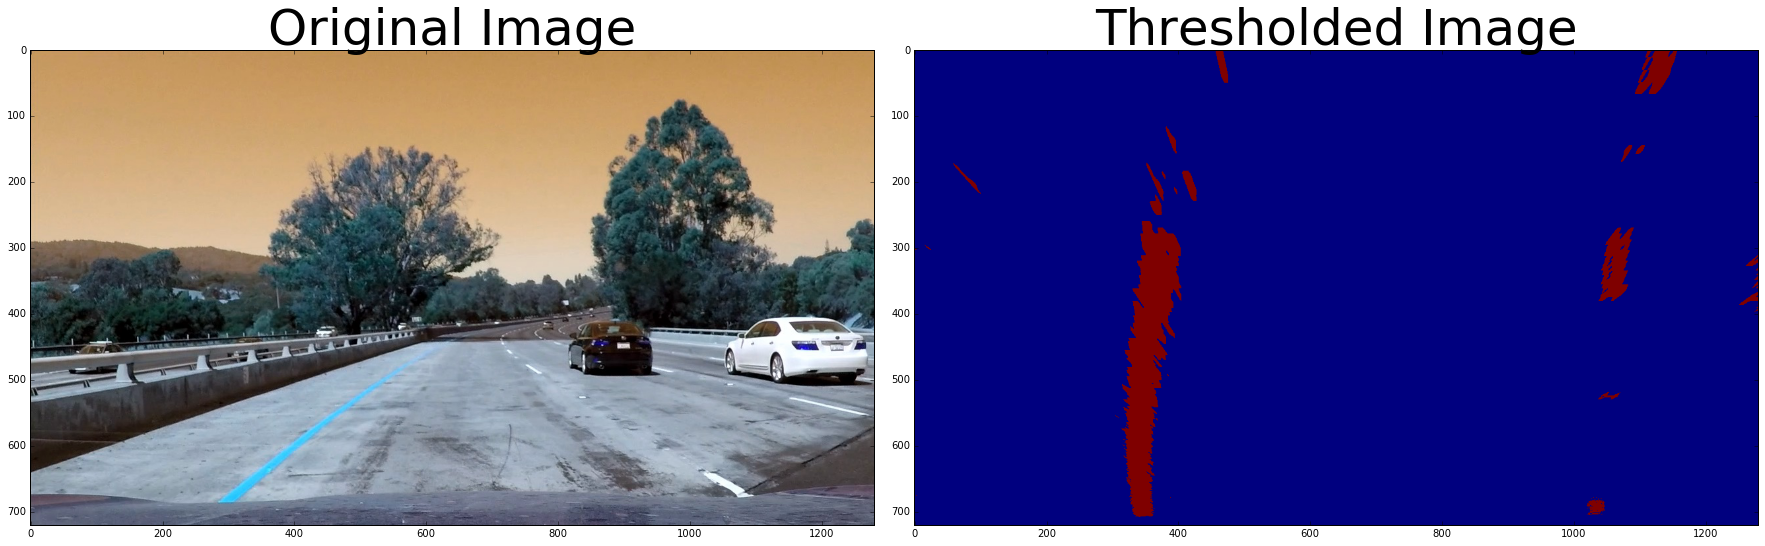

In [19]:
image = cv2.imread("../test_images/test1.jpg")
mtx,dist = camera_calibration(9,6)
undist = calc_distort(image,mtx,dist)
_,thres = combined_color(undist)
result = perspective_transform(thres)
f, (ax1, ax2) = plt.subplots(1,2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title("Original Image", fontsize = 50)
ax2.imshow(result)
ax2.set_title("Thresholded Image", fontsize = 50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

###  Image preprocessing

In [29]:
nx = 9
ny = 6
#camera calibration
mtx,dist =camera_calibration(nx,ny)

In [30]:
def pre_process(img):
    #Undistort the image 
    undist = calc_distort(img,mtx,dist)
    #Thresholded image 
    result_color,result_combined = combined_color(undist)
    #Perspective transform 
    pers_result = perspective_transform(result_combined) 
    return pers_result 

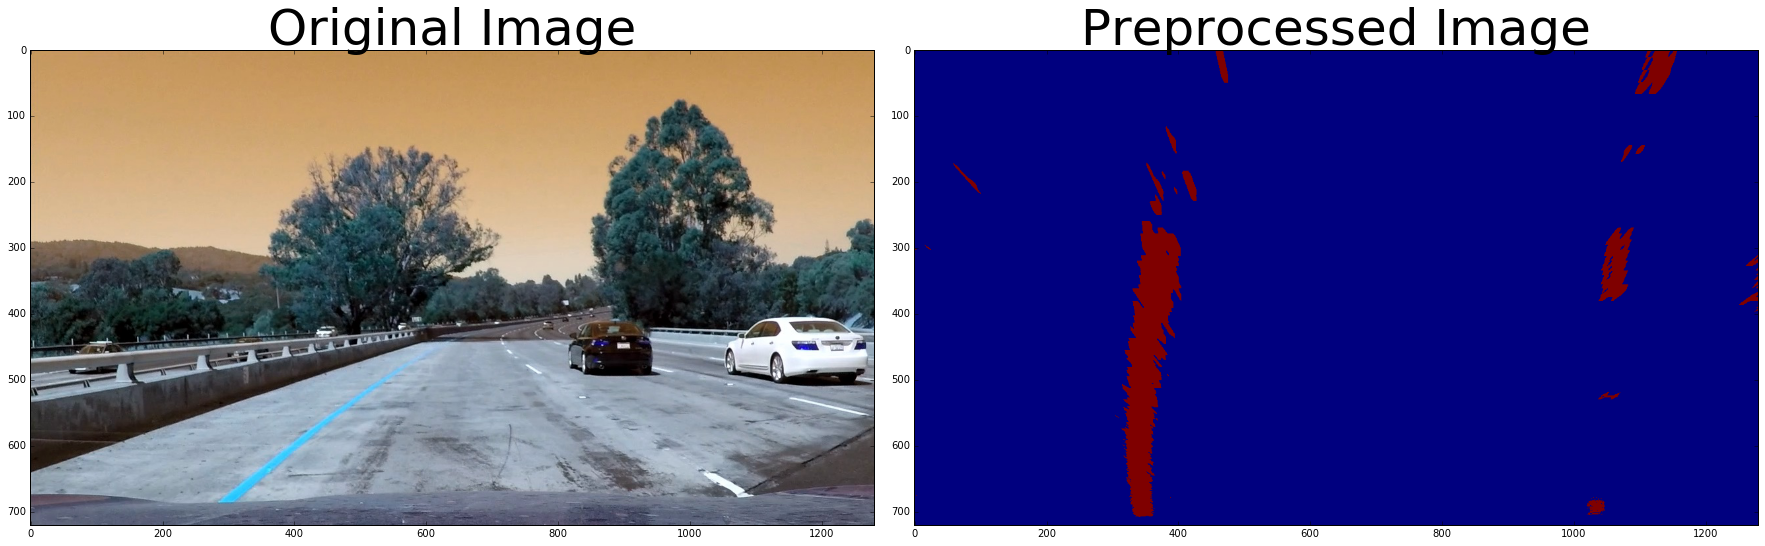

In [31]:
image = cv2.imread("../test_images/test1.jpg")
pers_result  = pre_process(image)
f, (ax1, ax2) = plt.subplots(1,2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title("Original Image", fontsize = 50)
ax2.imshow(pers_result)
ax2.set_title("Preprocessed Image", fontsize = 50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

### Detect Lane pixels and fit the lane boundary 

In [22]:
# Define a class to receive the characteristics of each line detection
from collections import deque
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None       
        #polynomial coefficients for the most recent fit
        self.current_fit = None 
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        self.recent_fits = deque(maxlen=30)
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None

In [23]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def fit_poly(binary_warped, image, left_line, right_line, plot=False):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    if (left_line.current_fit == None):
        midpoint = np.int(histogram.shape[0]/2)
        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint

        # Choose the number of sliding windows
        nwindows = 9
        # Set height of windows
        window_height = np.int(binary_warped.shape[0]/nwindows)
        # Identify the x and y positions of all nonzero pixels in the image
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Current positions to be updated for each window
        leftx_current = leftx_base
        rightx_current = rightx_base
        # Set the width of the windows +/- margin
        margin = 100
        # Set minimum number of pixels found to recenter window
        minpix = 50
        # Create empty lists to receive left and right lane pixel indices
        left_lane_inds = []
        right_lane_inds = []

        # Step through the windows one by one
        for window in range(nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = binary_warped.shape[0] - (window+1)*window_height
            win_y_high = binary_warped.shape[0] - window*window_height
            win_xleft_low = leftx_current - margin
            win_xleft_high = leftx_current + margin
            win_xright_low = rightx_current - margin
            win_xright_high = rightx_current + margin
            # Draw the windows on the visualization image
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
            # Identify the nonzero pixels in x and y within the window
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)
            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_left_inds) > minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > minpix:        
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
        # Concatenate the arrays of indices
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)

        # Extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds] 

        left_line.allx = leftx
        left_line.ally = lefty
        right_line.allx = rightx
        right_line.ally = righty

        # Fit a second order polynomial to each
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)
        ploty = np.linspace(0, 719, num=720)
   
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    else:
        left_fit = np.mean(np.asarray(left_line.recent_fits), axis=0)
        right_fit = np.mean(np.asarray(right_line.recent_fits), axis=0)
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        margin = 100
        left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
        right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

        # Again, extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]
        # Fit a second order polynomial to each
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)
        # Generate x and y values for plotting
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    y_eval = np.max(ploty)
    
    left_line.recent_fits.append(left_fit)
    right_line.recent_fits.append(right_fit)

    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])

    left_line.current_fit = left_fit
    right_line.current_fit = right_fit
    left_line.radius_of_curvature = left_curverad
    right_line.radius_of_curvature = right_curverad
        
    left_line.recent_xfitted.append(left_fitx)
    right_line.recent_xfitted.append(right_fitx)
    
    left_line.bestx = np.mean(np.asarray(left_line.recent_xfitted), axis=0)
    right_line.bestx = np.mean(np.asarray(right_line.recent_xfitted), axis=0)


    
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    if plot:
        plt.figure()
        plt.imshow(out_img)
        plt.plot(left_line.bestx , ploty, color='yellow')
        plt.plot(right_line.bestx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
        plt.show()
    Minv = cv2.getPerspectiveTransform(dst,src)

    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_line.bestx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_line.bestx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)

    curvature = (left_curverad + right_curverad) / 2
    cv2.putText(result, "Curvature: {0:.2f}m".format(curvature), (30,60), cv2.FONT_HERSHEY_SIMPLEX, 2, (255, 255, 255), thickness=10)
    
    bottom_leftx = left_fitx[-1]
    bottom_rightx = right_fitx[-1]
    
    lane_center = (bottom_leftx + bottom_rightx) / 2
    
    car_center = 1280 / 2
    
    difference = lane_center - car_center
    
    difference_meters = difference * xm_per_pix
    
    if difference < 0:
        cv2.putText(result, "{0:.2f}m right of center".format(difference_meters), (30,110), cv2.FONT_HERSHEY_SIMPLEX, 2, (255, 255, 255), thickness=10)
    else:
        cv2.putText(result, "{0:.2f}m left of center".format(difference_meters), (30,110), cv2.FONT_HERSHEY_SIMPLEX, 2, (255, 255, 255), thickness=10)

    if plot:
        plt.figure()
        plt.imshow(result)
        plt.show()
    return result

In [32]:
def pipeline(image,plot=False):
    pers_result  = pre_process(image)
    result = fit_poly(pers_result, image, left_line, right_line,plot)
    return result


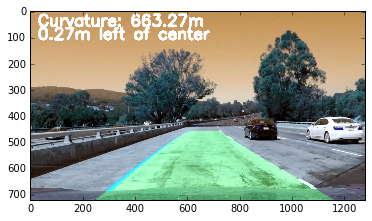

In [33]:
image = cv2.imread("../test_images/test1.jpg")
plt.imshow(image)
left_line = Line()
right_line = Line()
result = pipeline(image,plot=False)
plt.imshow(result)

In [ ]:
test_images = glob.glob('../test_images/*.jpg')
for image in test_images:
    image = cv2.imread(image)
    pipeline(image)

In [34]:
from moviepy.editor import *
out_video = "video_output.mp4"
left_line = Line()
right_line = Line()
video = VideoFileClip("project_video.mp4")
clip = video.fl_image(pipeline) 
%time clip.write_videofile(out_video, audio=False,verbose=False)


100%|█████████▉| 1260/1261 [02:58<00:00,  7.16it/s]


CPU times: user 3min 17s, sys: 56.2 s, total: 4min 14s
Wall time: 2min 59s
